# Image Selection (aka Masking)

In this tutorial, you will learn about how to select regions of interest
in images and how to exclude images with masks. The following ways exist
to create regions/masks:

* numpy/dask/xarray constructs to select portions of arrays,
* CRTF region strings and files, initially used in CASA 6,
* both simultaneously

In [1]:
import numpy as np
import xarray as xr
import dask.array as da
from pathlib import Path
import matplotlib.pyplot as plt

from astroviper.distributed.image_analysis.selection import (
    select_mask, apply_select, combine_with_creation
)

In [2]:
rng = np.random.default_rng(42)
ny, nx = 128, 160
y, x = np.mgrid[0:ny, 0:nx]
img = 0.1 + np.exp(-((x - nx / 2) ** 2) / (2 * 12.0 ** 2) - ((y - ny / 2) ** 2) / (2 * 8.0 ** 2))
# img = img + 0.05 * rng.normal(size=img.shape)
xda = xr.DataArray(img, dims=("y", "x"), coords={"y": np.arange(ny), "x": np.arange(nx)}, name="intensity")

Create and plot a model source

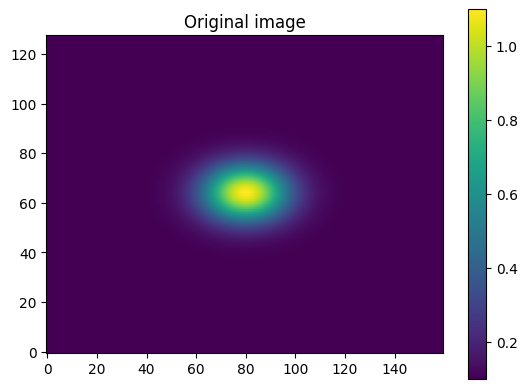

In [3]:
fig, ax = plt.subplots()
im = ax.imshow(xda, origin="lower")
ax.set_title("Original image")
fig.colorbar(im, ax=ax)
plt.show()

## **select=None** → use everything

mask_all dtype: bool true count: 20480


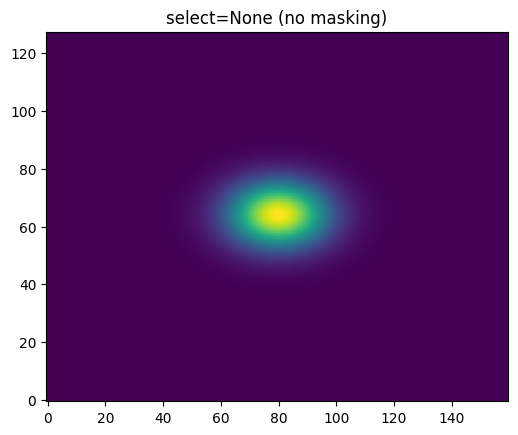

In [4]:
# creates an all True (nothing masked) selection/mask
mask_all = select_mask(xda, select=None)
# apply that selection, everything is selected
sel_all = apply_select(xda, select=None)

print("mask_all dtype:", mask_all.dtype, "true count:", int(mask_all.values.sum()))

fig, ax = plt.subplots()
ax.imshow(sel_all, origin="lower")
ax.set_title("select=None (no masking)")
plt.show()

## Boolean array-like (DataArray or ndarray selection)
Create a circular region of interest (ROI) mask and apply it.

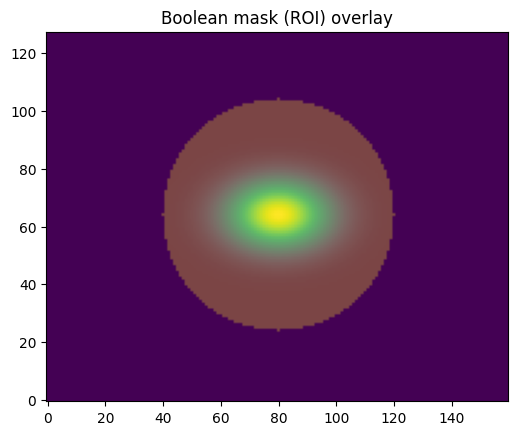

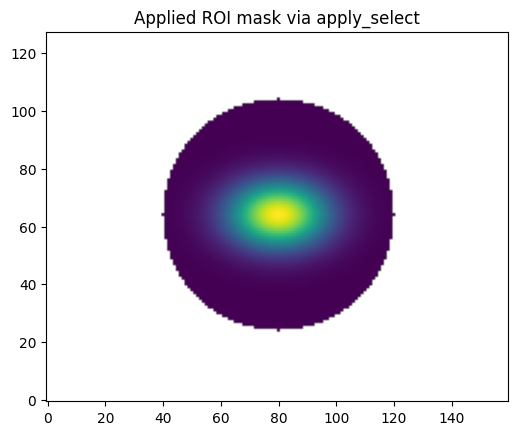

In [5]:
cy, cx = ny / 2, nx / 2
r = min(ny, nx) / 3.2  # why: focus on core region
roi = ((y - cy) ** 2 + (x - cx) ** 2) <= (r ** 2)
roi_da = xr.DataArray(roi, dims=("y", "x"), coords=xda.coords, name="roi")

mask_roi = select_mask(xda, select=roi_da)
sel_roi = apply_select(xda, select=roi_da)

# show the region to be applied
fig, ax = plt.subplots()
ax.imshow(xda, origin="lower")
ax.imshow(mask_roi, origin="lower", alpha=0.3)
ax.set_title("Boolean mask (ROI) overlay")
plt.show()

# apply the region
fig, ax = plt.subplots()
ax.imshow(sel_roi, origin="lower")
ax.set_title("Applied ROI mask via apply_select")
plt.show()

## String expression over named masks ("roi & ~bad & ~sidelobe")
Build masks and a `mask_source` mapping and use an expression.

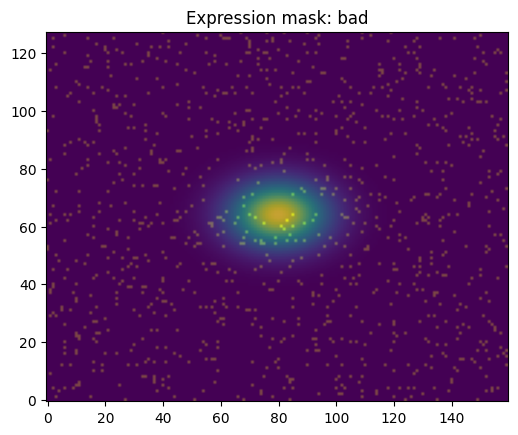

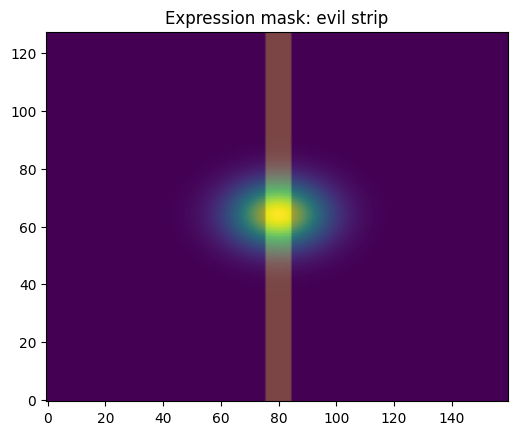

expr true count: 4095 of 20480


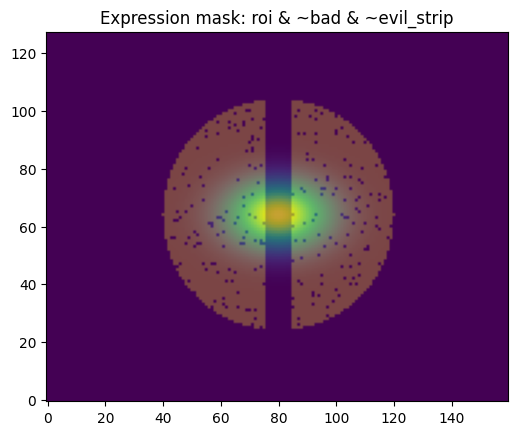

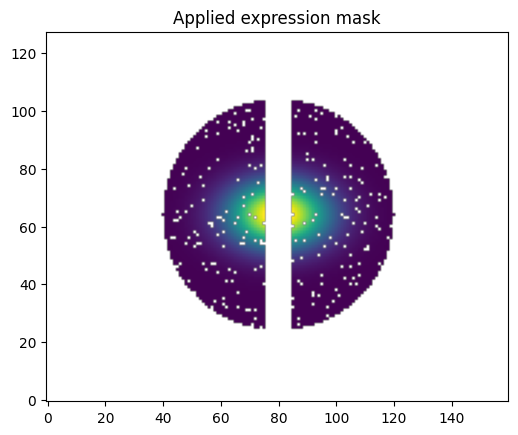

In [6]:
bad = rng.random((ny, nx)) < 0.05

expr = "bad"
fig, ax = plt.subplots()
ax.imshow(xda, origin="lower")
ax.imshow(bad, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()

evil_strip = (x > nx/2 - 5) & (x < nx/2 +5) 

expr = "evil strip"
fig, ax = plt.subplots()
ax.imshow(xda, origin="lower")
ax.imshow(evil_strip, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()


mask_source = {
    "roi": roi_da,                                 # keep xarray to preserve coords
    "bad": xr.DataArray(bad, dims=("y", "x"), coords=xda.coords),
    "evil_strip": xr.DataArray(evil_strip, dims=("y", "x"), coords=xda.coords),
}

expr = "roi & ~bad & ~evil_strip"
# expr = "roi & ~sidelobe"

mask_expr = select_mask(xda, select=expr, mask_source=mask_source)
sel_expr = apply_select(xda, select=expr, mask_source=mask_source)

print(
    "expr true count:", int(mask_expr.values.sum()),
    "of", mask_expr.size,
)

fig, ax = plt.subplots()
ax.imshow(xda, origin="lower")
ax.imshow(mask_expr, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()

fig, ax = plt.subplots()
ax.imshow(sel_expr, origin="lower")
ax.set_title("Applied expression mask")
plt.show()


## CRTF (CASA 6) region support.

Data: simple image with a bright blob

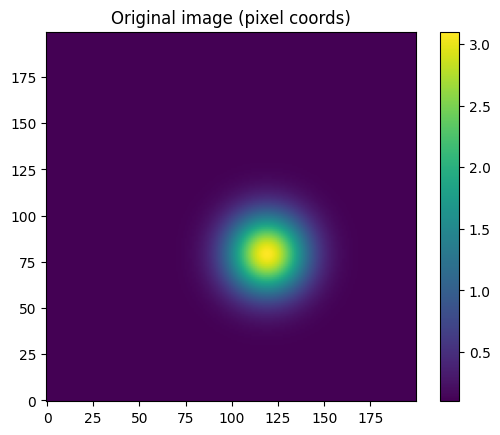

In [7]:
ny = nx = 200
x = np.arange(1, nx + 1)  # pixel centers 1..nx
y = np.arange(1, ny + 1)  # pixel centers 1..ny
X, Y = np.meshgrid(x, y)
Z = 0.1 + 3.0 * np.exp(-((X - 120) ** 2 + (Y - 80) ** 2) / (2 * 15 ** 2))
xda = xr.DataArray(Z, dims=("y", "x"), coords={"x": x, "y": y}, name="intensity")

fig, ax = plt.subplots()
im = ax.imshow(xda, origin="lower")
ax.set_title("Original image (pixel coords)")
fig.colorbar(im, ax=ax)
plt.show()

Utility to overlay masks

In [8]:
def show_mask(ax, data: xr.DataArray, mask: xr.DataArray, title: str):
    # base image
    ax.imshow(data, origin="lower", interpolation="none")
    # dim the outside region
    ax.imshow(~mask, origin="lower", interpolation="none", alpha=0.18)
    # highlight the kept region
    ax.imshow(np.ma.masked_where(~mask, data), origin="lower", interpolation="none", alpha=0.85)
    # draw a crisp boundary
    ax.contour(mask, levels=[0.5], colors="k", linewidths=1.2, origin="lower")
    ax.set_title(title)

## Box region
CRTF header is optional — both forms are supported. Currently only pixel coordinates are supported.
Pixel coordinate values are interpreted as being 0-based.

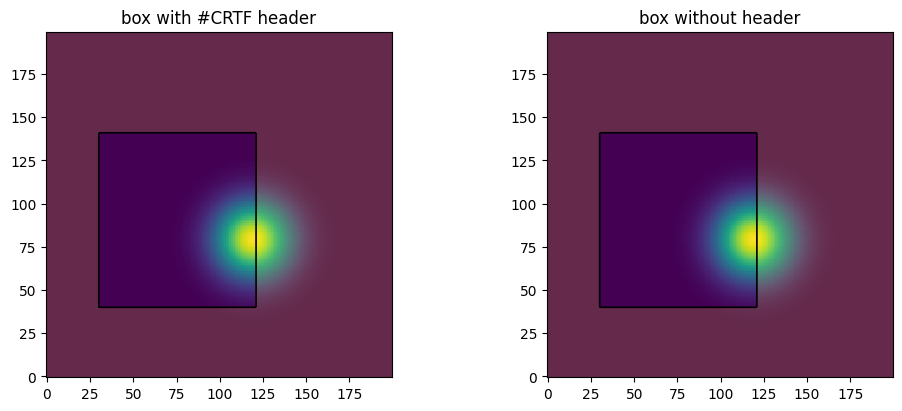

In [9]:
crtf_with_header = """
#CRTF
box[[ 30pix, 40pix ], [ 120pix, 140pix ]]
""".strip()

crtf_no_header = "box[[30pix,40pix],[120pix,140pix]]"

mask1 = select_mask(xda, select=crtf_with_header)
mask1b = select_mask(xda, select=crtf_no_header)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
show_mask(ax1, xda, mask1, "box with #CRTF header")
show_mask(ax2, xda, mask1b, "box without header")
plt.show()

Apply the regions.

selected pixel count: 9191
masked mean (finite only): 0.34804805841703373


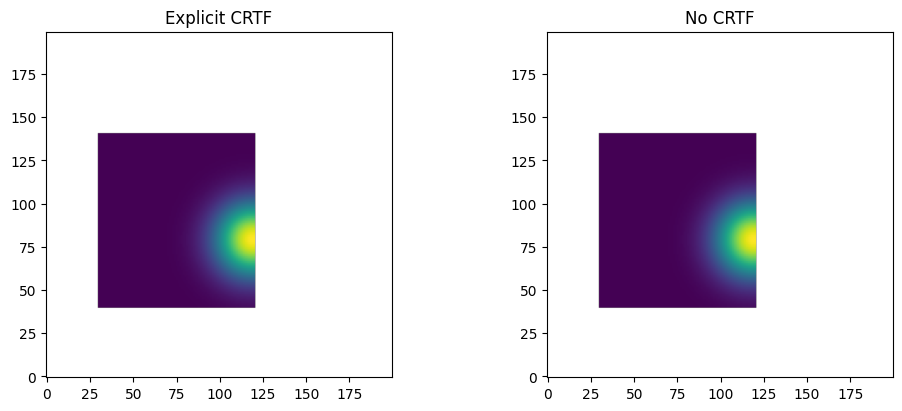

In [10]:
sel = apply_select(xda, select=mask1)
selb = apply_select(xda, select=mask1b)

print("selected pixel count:", int(select_mask(xda, select=sel).values.sum()))
print("masked mean (finite only):", float(np.nanmean(sel)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
ax1.imshow(sel, origin="lower")
ax2.imshow(selb, origin="lower")
ax1.set_title("Explicit CRTF")
ax2.set_title("No CRTF")
plt.show()

## Rotated box (rotbox)
Syntax: `rotbox[[cx,cy],[width,height], mode=angle]`; angle in `deg` or `rad` (default = deg).

The angle can be measured in one of two ways (modes). **mode=theta_m** means use convention where the angle is measured from the +x axis to the +y axis. **pa** means measure from the +y axis to the +x axis. Both are coordinate system handedness agnostic. The specific mode keyword is required to avoid ambiguity.

In this example, we use theta_m as the mode keyword. The angle is thus measured from +x -> +y.

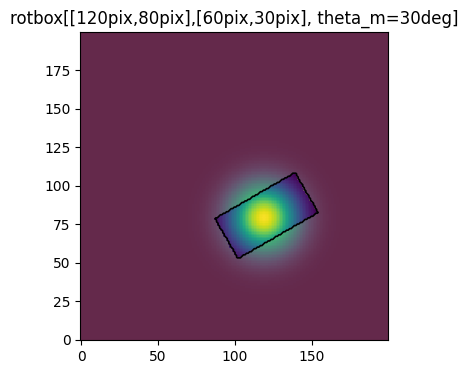

In [11]:
rot = "rotbox[[120pix,80pix],[60pix,30pix], theta_m=30deg]"
mask_rot = select_mask(xda, select=rot)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_rot, rot)
plt.show()

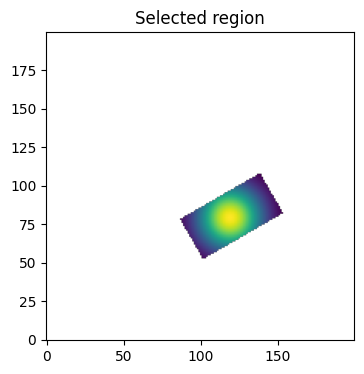

In [12]:
sel = apply_select(xda, select=mask_rot)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel, origin="lower")
ax.set_title("Selected region")
plt.show()

Here we use the mode of pa, so that the rotation angle is measured from +y -> +x

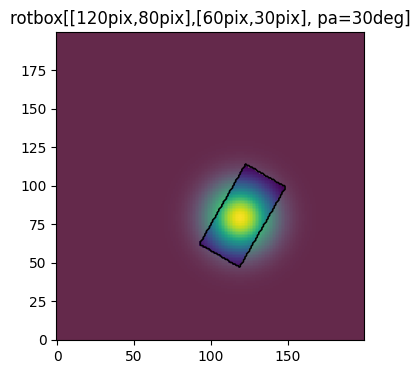

In [13]:
rot = "rotbox[[120pix,80pix],[60pix,30pix], pa=30deg]"
mask_rot_pa = select_mask(xda, select=rot)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_rot_pa, rot)
plt.show()

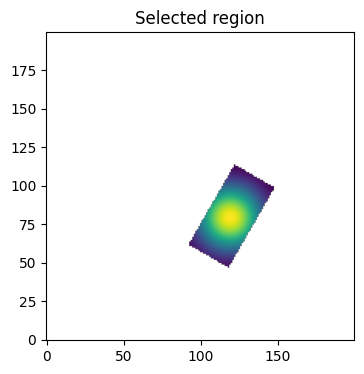

In [14]:
sel = apply_select(xda, select=mask_rot_pa)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel, origin="lower")
ax.set_title("Selected region")
plt.show()

## Circle and annulus

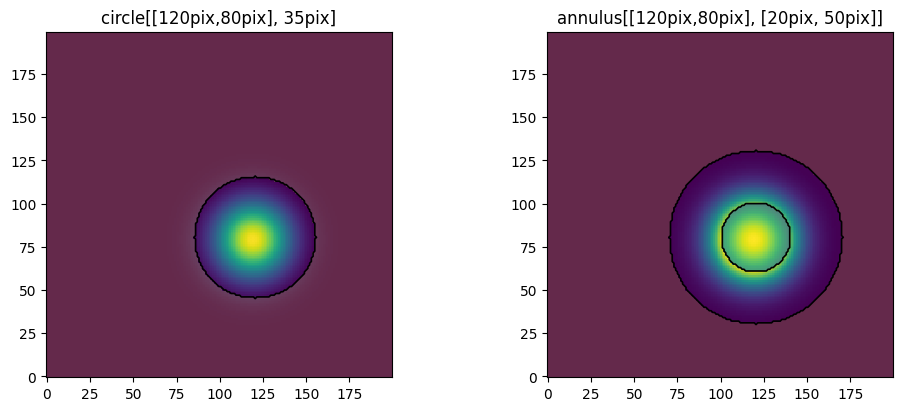

In [15]:
circle = "circle[[120pix,80pix], 35pix]"
annulus = "annulus[[120pix,80pix], [20pix, 50pix]]"
mask_circle = select_mask(xda, select=circle)
mask_ann = select_mask(xda, select=annulus)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
show_mask(ax1, xda, mask_circle, circle)
show_mask(ax2, xda, mask_ann, annulus)
plt.show()

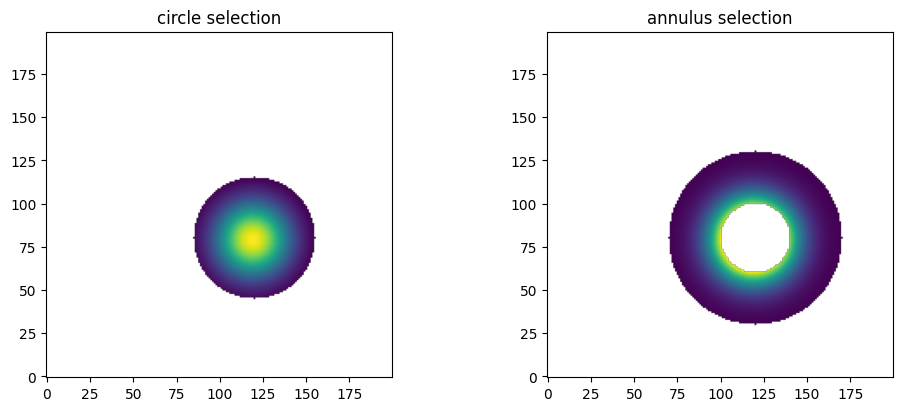

In [16]:
sel_circle = apply_select(xda, select=mask_circle)
sel_ann = apply_select(xda, select=mask_ann)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
ax1.imshow(sel_circle, origin="lower")
ax2.imshow(sel_ann, origin="lower")
ax1.set_title("circle selection")
ax2.set_title("annulus selection")
plt.show()

## Ellipse with position angle
Format: `ellipse[[cx,cy], [a,b], pa]` where `a`, `b` are **semi-axes in pixels**.

As with rotbox, the angle convention must be specified.

The first example uses theta_m (+x -> +y)

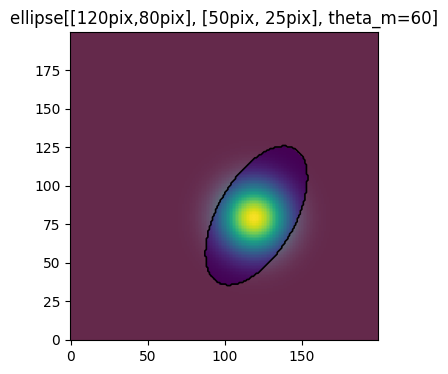

In [17]:
ellipse = "ellipse[[120pix,80pix], [50pix, 25pix], theta_m=60]"  # 60 degrees
mask_ellipse = select_mask(xda, select=ellipse)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_ellipse, ellipse)
plt.show()

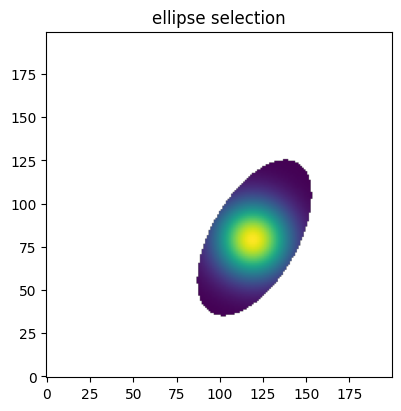

In [18]:
sel_ellipse = apply_select(xda, select=mask_ellipse)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
ax.imshow(sel_ellipse, origin="lower")
ax.set_title("ellipse selection")
plt.show()

In the following example, we use pa rotation angle convention (+y -> +x)

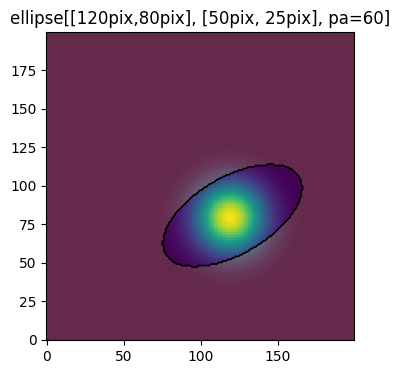

In [19]:
ellipse_pa = "ellipse[[120pix,80pix], [50pix, 25pix], pa=60]"  # 60 degrees
mask_ellipse_pa = select_mask(xda, select=ellipse_pa)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_ellipse_pa, ellipse_pa)
plt.show()

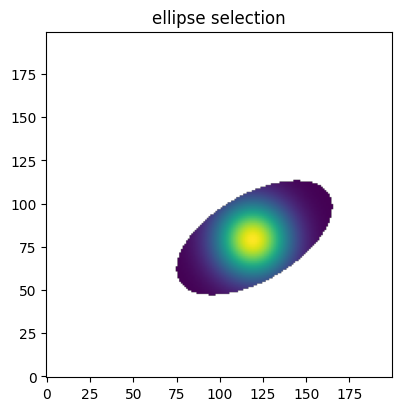

In [20]:
sel_ellipse_pa = apply_select(xda, select=mask_ellipse_pa)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
ax.imshow(sel_ellipse_pa, origin="lower")
ax.set_title("ellipse selection")
plt.show()

## Polygon (poly)

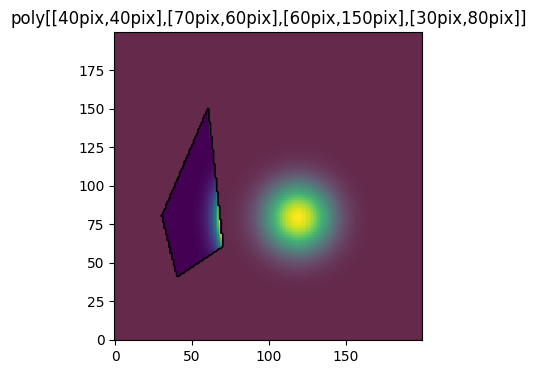

In [21]:
poly = "poly[[40pix,40pix],[70pix,60pix],[60pix,150pix],[30pix,80pix]]"
mask_poly = select_mask(xda, select=poly)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_poly, poly)
plt.show()

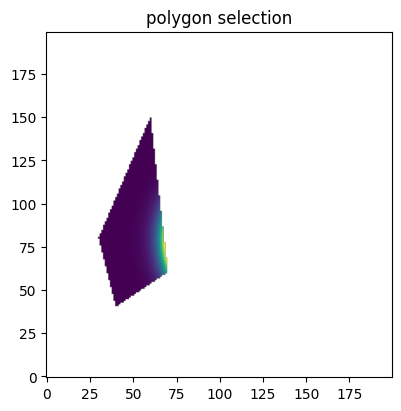

In [22]:
sel_poly = apply_select(xda, select=mask_poly)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
ax.imshow(sel_poly, origin="lower")
ax.set_title("polygon selection")
plt.show()

## Multiple CRTF specifications with `+` (OR) and `-` (subtract)
Lines are combined; default is `+` if no prefix.

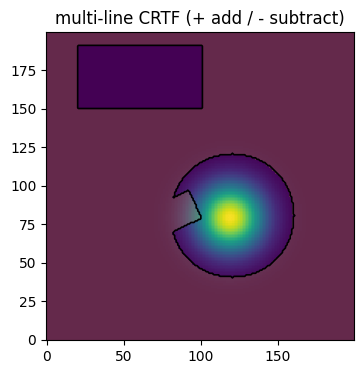

In [23]:
multi = """
#CRTF
+circle[[120pix,80pix], 40pix]
-rotbox[[80pix,80pix],[35pix,20pix], theta_m=25deg]
+box[[20pix,150pix],[100pix,190pix]]
""".strip()

mask_multi = select_mask(xda, select=multi)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_multi, "multi-line CRTF (+ add / - subtract)")
plt.show()

Apply selection to the image and compute simple stats

selected pixel count: 8012
masked mean (finite only): 0.5975197358414125


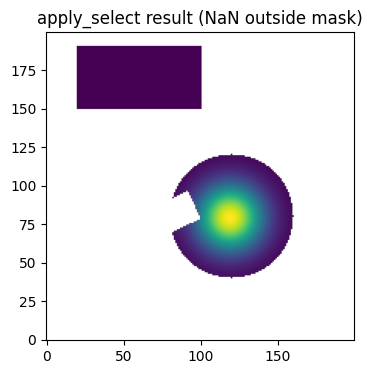

In [24]:
sel = apply_select(xda, select=multi)

print("selected pixel count:", int(select_mask(xda, select=multi).values.sum()))
print("masked mean (finite only):", float(np.nanmean(sel)))

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel, origin="lower")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()

### Mixing CRTF with named-mask expressions
If the string **is not** detected as CRTF, it is treated as a named-mask expression.

This example uses `roi & edge` combining masks provided in a mapping or dataset. The
& means include only pixels that are present in both selections; it is an
intersection operator.

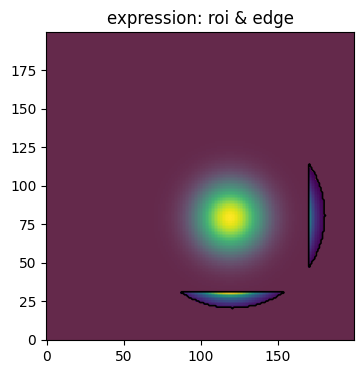

In [25]:
roi = select_mask(xda, select="circle[[120pix,80pix], 60pix]")
edge = (
    select_mask(xda, select="box[[1pix,1pix],[200pix,30pix]]")
    | select_mask(xda, select="box[[270pix,1pix],[170pix,200pix]]")
)
mask_source = {"roi": roi, "edge": edge}
expr = "roi & edge"
mask_expr = select_mask(xda, select=expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_expr, f"expression: {expr}")
plt.show()

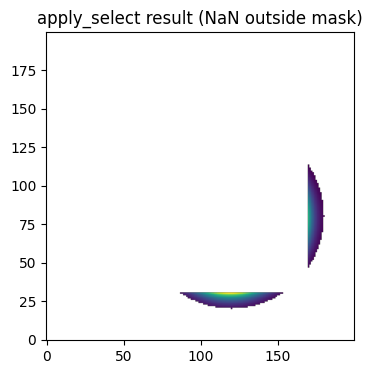

In [26]:
sel_expr = apply_select(xda, select=mask_expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel_expr, origin="lower")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()

Here we use `roi & -edge` (note the minus sign which negates the selection; **edge**
is excluded from the region selection)

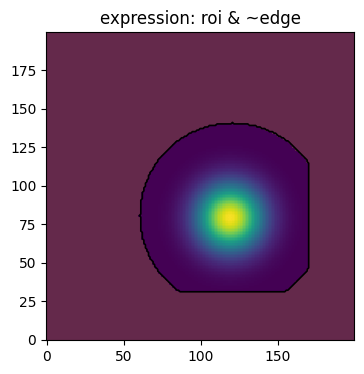

In [27]:
expr = "roi & ~edge"
mask_expr = select_mask(xda, select=expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_expr, f"expression: {expr}")
plt.show()

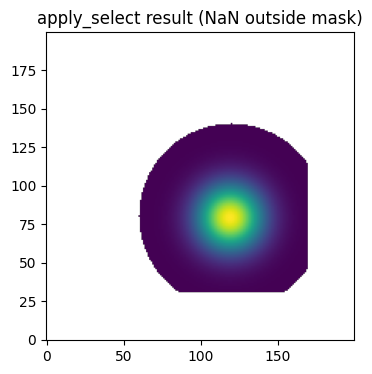

In [28]:
sel_expr = apply_select(xda, select=mask_expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel_expr, origin="lower")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()

Here we OR (|) the regions together, which results in the union of the two regions

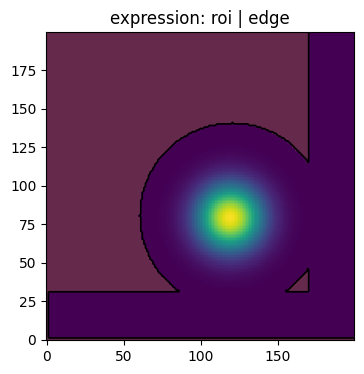

In [29]:
expr = "roi | edge"
mask_expr = select_mask(xda, select=expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_expr, f"expression: {expr}")
plt.show()

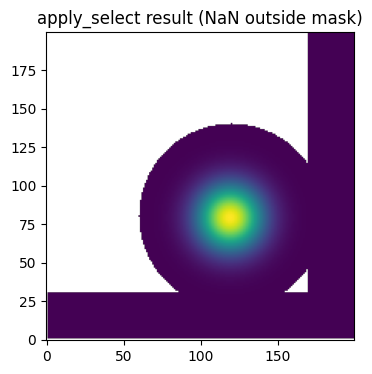

In [30]:
sel_expr = apply_select(xda, select=mask_expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel_expr, origin="lower")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()

Here we create the union of roi and the negation of edge.

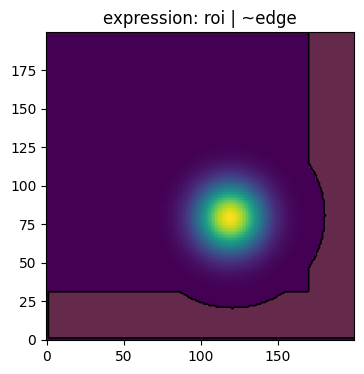

In [31]:
expr = "roi | ~edge"
mask_expr = select_mask(xda, select=expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, xda, mask_expr, f"expression: {expr}")
plt.show()

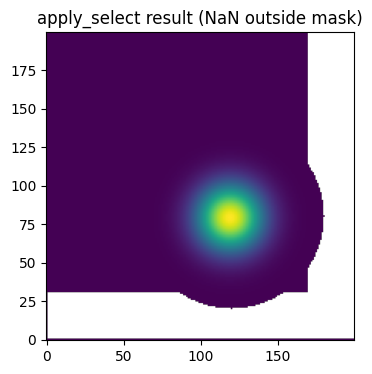

In [32]:
sel_expr = apply_select(xda, select=mask_expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel_expr, origin="lower")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()

## Using CRTF files with `select_mask`
Pixel-only CRTF support (box, centerbox, rotbox, circle, ellipse, poly, annulus).
Files can be referenced via **backticked strings** (e.g. ``"`regions/roi.crtf`"``)
or a `pathlib.Path`.

### Create a toy image with pixel coordinates 1..N

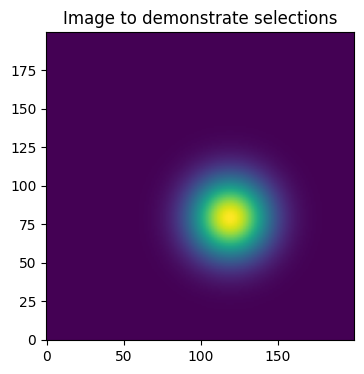

In [33]:
ny = nx = 200
x = np.arange(1, nx + 1)
y = np.arange(1, ny + 1)
X, Y = np.meshgrid(x, y)
Z = 0.1 + 2.5 * np.exp(-((X - 120) ** 2 + (Y - 80) ** 2) / (2 * 18 ** 2))
xda = xr.DataArray(Z, dims=("y", "x"), coords={"x": x, "y": y}, name="intensity")

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(xda, origin="lower")
ax.set_title("Image to demonstrate selections")
plt.show()

### Write a CRTF file to disk
The header `#CRTF` is optional.

In [34]:
regions_dir = Path("regions")
regions_dir.mkdir(exist_ok=True)
crtf_path = regions_dir / "roi.crtf"
crtf_text = """
#CRTF
+circle[[120pix,80pix], 40pix]
-rotbox[[120pix,80pix],[36pix,18pix], theta_m=30deg]
+box[[20pix,160pix],[70pix,190pix]]
""".strip()
crtf_path.write_text(crtf_text, encoding="utf-8")
print("Wrote:", crtf_path)

Wrote: regions/roi.crtf


### Load the CRTF file in two supported ways
1) Backticked string literal **inside** a normal Python string.
2) `Path` object.

In [35]:
mask_file_bt = select_mask(xda, select=f"`{crtf_path.as_posix()}`")
mask_file_p = select_mask(xda, select=crtf_path)

# Sanity: both should match
if isinstance(mask_file_bt, xr.DataArray):
    assert (mask_file_bt == mask_file_p).all(), "Backtick and Path forms must produce identical masks"
else:
    assert _np.array_equal(mask_file_bt, mask_file_p)


### Compare against the same CRTF provided inline as a string

In [36]:
mask_inline = select_mask(xda, select=crtf_text)
assert (mask_file_bt == mask_inline).all(), "File and inline CRTF should be identical"
print("Mask pixels (inline):", int(mask_inline.values.sum()))

Mask pixels (inline): 5955


### Visualize — make boundaries obvious

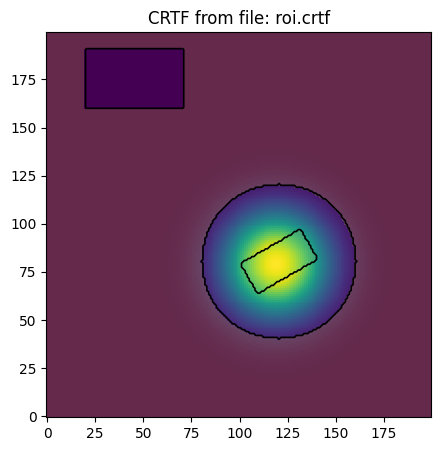

In [37]:
def show_mask(ax, data: xr.DataArray, mask: xr.DataArray, title: str):
    ax.imshow(data, origin="lower", interpolation="none")
    # dim outside, highlight inside
    ax.imshow(~mask, origin="lower", interpolation="none", alpha=0.18)
    ax.imshow(np.ma.masked_where(~mask, data), origin="lower", interpolation="none", alpha=0.85)
    # crisp boundary
    ax.contour(mask, levels=[0.5], colors="k", linewidths=1.2, origin="lower")
    ax.set_title(title)

fig, ax = plt.subplots(figsize=(6, 5))
show_mask(ax, xda, mask_inline, f"CRTF from file: {crtf_path.name}")
plt.show()

### Apply the selection to the image

Selected pixel count: 5955
Masked mean (finite only): 0.6580122995952088


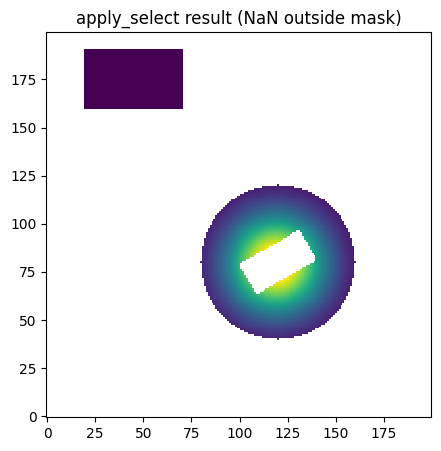

In [38]:
sel = apply_select(xda, select=f"`{crtf_path.as_posix()}`")
print("Selected pixel count:", int(select_mask(xda, select=f"`{crtf_path.as_posix()}`").values.sum()))
print("Masked mean (finite only):", float(np.nanmean(sel)))

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(sel, origin="lower", interpolation="none")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()

# Selection masks: inputs × outputs

Quick tour of `select_mask(..., return_kind=...)` with NumPy / xarray (NumPy + Dask) inputs, CRTF strings & expressions, and all four output kinds:  
`"numpy"`, `"dask"`, `"dataarray-numpy"`, `"dataarray-dask"` (default).


## Helpers

In [39]:
def _as_numpy_mask(mask):
    """Return a NumPy bool array for visualization."""
    if isinstance(mask, xr.DataArray):
        arr = mask.data
    else:
        arr = mask
    if hasattr(arr, "compute"):  # dask
        arr = arr.compute()
    return np.asarray(arr, dtype=bool)

def _as_numpy_img(data):
    """Return a NumPy float array for visualization."""
    if isinstance(data, xr.DataArray):
        arr = data.data
    else:
        arr = data
    if hasattr(arr, "compute"):  # dask
        arr = arr.compute()
    return np.asarray(arr)

def show_mask(ax, data, mask, title):
    ax.set_title(title)
    img = _as_numpy_img(data)
    m = _as_numpy_mask(mask)
    ax.imshow(img, origin="lower", alpha=0.5)
    ax.imshow(m, origin="lower", alpha=0.4)
    ax.axis("off")

def describe(name, arr):
    kind = type(arr).__name__
    if isinstance(arr, xr.DataArray):
        backing = type(arr.data).__name__
        chunks = getattr(arr.data, "chunks", None)
        print(f"{name}: xr.DataArray<{backing}>, shape={arr.shape}, chunks={chunks}")
    else:
        chunks = getattr(arr, "chunks", None)
        print(f"{name}: {kind}, shape={np.shape(arr)}, chunks={chunks}")

## Create sample data (NumPy, DataArray[NumPy], DataArray[Dask])

In [40]:
print(da)
ny, nx = 120, 160
da.zeros((ny, nx), chunks=(40, 40))
data_np = np.zeros((ny, nx), dtype=float)
data_da_np = xr.DataArray(np.zeros((ny, nx), dtype=float), dims=("y", "x"))
data_da_dask = xr.DataArray(da.zeros((ny, nx), chunks=(40, 40)), dims=("y", "x"))

describe("data_np", data_np)
describe("data_da_np", data_da_np)
describe("data_da_dask", data_da_dask)

<module 'dask.array' from '/home/dmehring/miniforge3/envs/astroviper/lib/python3.12/site-packages/dask/array/__init__.py'>
data_np: ndarray, shape=(120, 160), chunks=None
data_da_np: xr.DataArray<ndarray>, shape=(120, 160), chunks=None
data_da_dask: xr.DataArray<Array>, shape=(120, 160), chunks=((40, 40, 40), (40, 40, 40, 40))


## Define selections: CRTF (pixel) and expressions

In [41]:
# Pixel CRTF strings (0-based with 'pix' units)
crtf_box = """
#CRTF
box[[20pix, 25pix], [90pix, 80pix]]
""".strip()

crtf_circle = "circle[[60pix,60pix], 30pix]"

# Named masks for expressions
roi = select_mask(data_da_np, select=crtf_box, return_kind="dataarray-numpy")
bad = xr.DataArray(np.zeros((ny, nx), dtype=int), dims=("y", "x"))
bad.values[10:20, 10:30] = 1

expr = "roi & ~bad"
mask_src = {"roi": roi, "bad": bad}

describe("roi", roi)
describe("bad", bad)

roi: xr.DataArray<ndarray>, shape=(120, 160), chunks=None
bad: xr.DataArray<ndarray>, shape=(120, 160), chunks=None


## NumPy data → all return kinds

m_np_numpy: ndarray, shape=(120, 160), chunks=None
m_np_dask: Array, shape=(120, 160), chunks=((40, 40, 40), (40, 40, 40, 40))
m_np_danp: xr.DataArray<ndarray>, shape=(120, 160), chunks=None
m_np_dadask: xr.DataArray<Array>, shape=(120, 160), chunks=((40, 40, 40), (40, 40, 40, 40))


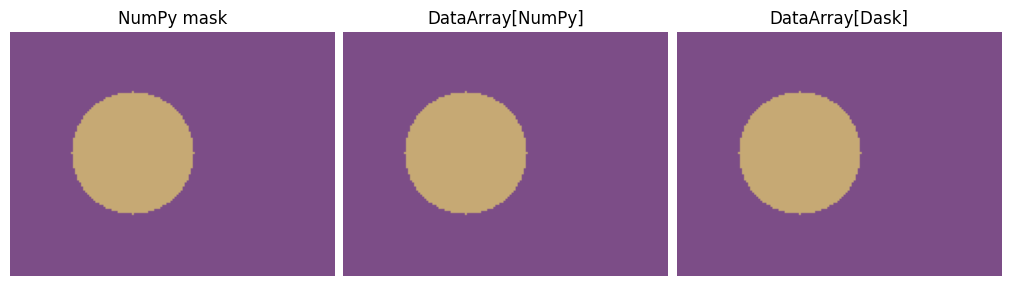

In [42]:
m_np_numpy  = select_mask(data_np, select=crtf_circle, return_kind="numpy")
m_np_dask   = select_mask(data_np, select=crtf_circle, return_kind="dask", dask_chunks=(40, 40))
m_np_danp   = select_mask(data_np, select=crtf_circle, return_kind="dataarray-numpy")
m_np_dadask = select_mask(data_np, select=crtf_circle, return_kind="dataarray-dask", dask_chunks=(40, 40))

describe("m_np_numpy", m_np_numpy)
describe("m_np_dask", m_np_dask)
describe("m_np_danp", m_np_danp)
describe("m_np_dadask", m_np_dadask)

fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
show_mask(axs[0], data_np, m_np_numpy, "NumPy mask")
show_mask(axs[1], data_np, m_np_danp, "DataArray[NumPy]")
show_mask(axs[2], data_np, m_np_dadask, "DataArray[Dask]")
plt.show()

## DataArray[NumPy] data → all return kinds (expression path)

m_danp_numpy: ndarray, shape=(120, 160), chunks=None
m_danp_dask: Array, shape=(120, 160), chunks=((120,), (160,))
m_danp_danp: xr.DataArray<ndarray>, shape=(120, 160), chunks=None
m_danp_dadask: xr.DataArray<Array>, shape=(120, 160), chunks=((120,), (160,))


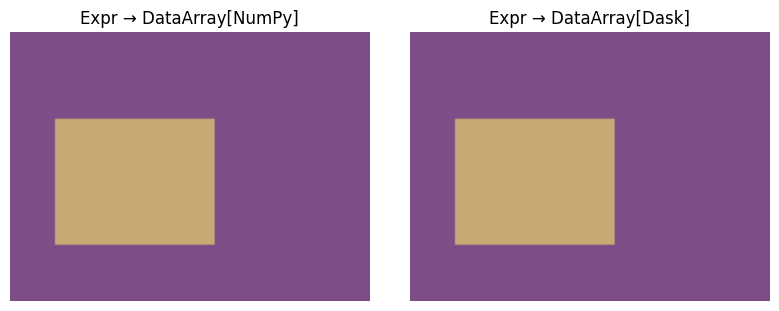

In [43]:
m_danp_numpy  = select_mask(data_da_np, select=expr, mask_source=mask_src, return_kind="numpy")
m_danp_dask   = select_mask(data_da_np, select=expr, mask_source=mask_src, return_kind="dask")
m_danp_danp   = select_mask(data_da_np, select=expr, mask_source=mask_src, return_kind="dataarray-numpy")
m_danp_dadask = select_mask(data_da_np, select=expr, mask_source=mask_src, return_kind="dataarray-dask")

describe("m_danp_numpy", m_danp_numpy)
describe("m_danp_dask", m_danp_dask)
describe("m_danp_danp", m_danp_danp)
describe("m_danp_dadask", m_danp_dadask)

fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
show_mask(axs[0], data_da_np, m_danp_danp, "Expr → DataArray[NumPy]")
show_mask(axs[1], data_da_np, m_danp_dadask, "Expr → DataArray[Dask]")
plt.show()

## DataArray[Dask] data → all return kinds (CRTF path)

m_dadask_numpy: ndarray, shape=(120, 160), chunks=None
m_dadask_dask: Array, shape=(120, 160), chunks=((120,), (160,))
m_dadask_danp: xr.DataArray<ndarray>, shape=(120, 160), chunks=None
m_dadask_dadask: xr.DataArray<Array>, shape=(120, 160), chunks=((120,), (160,))


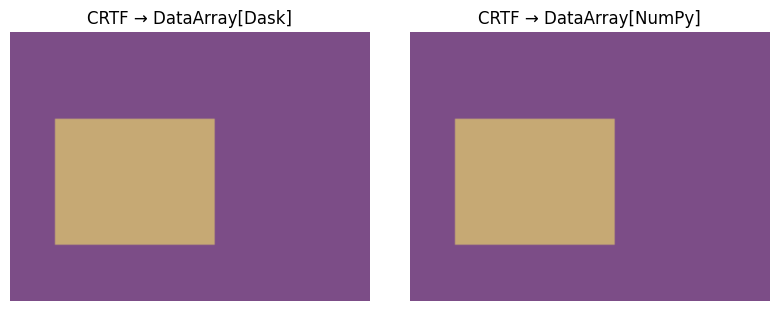

In [44]:
m_dadask_numpy  = select_mask(data_da_dask, select=crtf_box, return_kind="numpy")
m_dadask_dask   = select_mask(data_da_dask, select=crtf_box, return_kind="dask")
m_dadask_danp   = select_mask(data_da_dask, select=crtf_box, return_kind="dataarray-numpy")
m_dadask_dadask = select_mask(data_da_dask, select=crtf_box, return_kind="dataarray-dask")

describe("m_dadask_numpy", m_dadask_numpy)
describe("m_dadask_dask", m_dadask_dask)
describe("m_dadask_danp", m_dadask_danp)
describe("m_dadask_dadask", m_dadask_dadask)

fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
show_mask(axs[0], data_da_dask, m_dadask_dadask, "CRTF → DataArray[Dask]")
show_mask(axs[1], data_da_dask, m_dadask_danp, "CRTF → DataArray[NumPy]")
plt.show()

## Applying selections to data

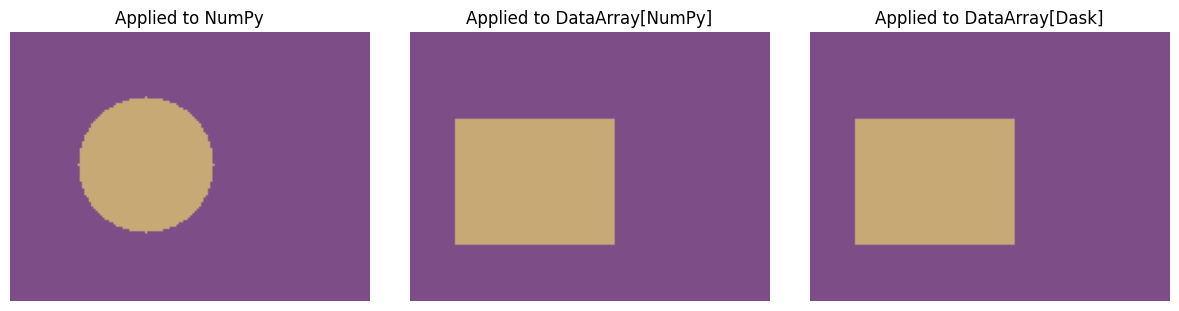

In [45]:
sel_np = apply_select(data_np, select=crtf_circle)
sel_da_np = apply_select(data_da_np, select=expr, mask_source=mask_src)
sel_da_dask = apply_select(data_da_dask, select=crtf_box)

fig, axs = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)
show_mask(axs[0], data_np, m_np_numpy, "Applied to NumPy")
show_mask(axs[1], data_da_np, m_danp_danp, "Applied to DataArray[NumPy]")
show_mask(axs[2], data_da_dask, m_dadask_dadask, "Applied to DataArray[Dask]")
plt.show()

## CRTF file usage: backticked path and `Path`

m_inline: xr.DataArray<Array>, shape=(120, 160), chunks=((120,), (160,))
m_bt: xr.DataArray<Array>, shape=(120, 160), chunks=((120,), (160,))
m_path: xr.DataArray<Array>, shape=(120, 160), chunks=((120,), (160,))


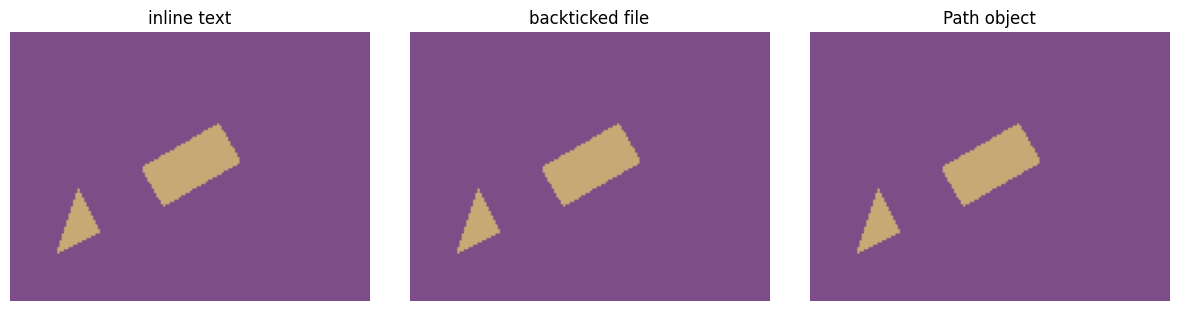

In [46]:
crtf_text = """
#CRTF
# an example file
rotbox[[80pix,60pix],[40pix,20pix], theta_m=30]
poly[[20pix,20pix],[40pix,30pix],[30pix,50pix]]
""".strip()

crtf_path = Path("example.crtf")
_ = crtf_path.write_text(crtf_text, encoding="utf-8")

m_inline = select_mask(data_da_np, select=crtf_text)
m_bt = select_mask(data_da_np, select=f"`{crtf_path.as_posix()}`")
m_path = select_mask(data_da_np, select=crtf_path)

describe("m_inline", m_inline)
describe("m_bt", m_bt)
describe("m_path", m_path)

fig, axs = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)
show_mask(axs[0], data_da_np, m_inline, "inline text")
show_mask(axs[1], data_da_np, m_bt, "backticked file")
show_mask(axs[2], data_da_np, m_path, "Path object")
plt.show()

## Laziness and compute()

In [47]:
m_lazy = select_mask(data_da_dask, select=crtf_circle, return_kind="dask", dask_chunks=(40, 40))
print("lazy?", hasattr(m_lazy, "compute"))
m_eager = m_lazy.compute()

describe("m_lazy", m_lazy)
describe("m_eager", m_eager)

lazy? True
m_lazy: Array, shape=(120, 160), chunks=((120,), (160,))
m_eager: ndarray, shape=(120, 160), chunks=None


# Selection “creation” attribute demo

This notebook demonstrates how `select_mask` attaches a `creation` attribute to **xarray.DataArray** masks, preserving the string (CRTF or expression) or file reference used to create the mask. It also shows a tiny helper to preserve/merge `creation` when you combine masks with bitwise ops.

In [48]:
# Make a sample image (xarray, coordinates optional)
ny, nx = 200, 300
xda = xr.DataArray(np.zeros((ny, nx), dtype=float), dims=("y", "x"))

## Inline CRTF string ⇒ DataArray with `attrs["creation"]`

In [49]:
crtf_inline = """
#CRTF
+circle[[120pix,80pix], 40pix]
-rotbox[[120pix,80pix],[36pix,18pix], theta_m=30]
+box[[20pix,160pix],[70pix,190pix]]
""".strip()

mask_inline = select_mask(xda, select=crtf_inline)  # default return_kind: dataarray-dask

print("type:", type(mask_inline).__name__)
print("has creation:", "creation" in mask_inline.attrs)
print("creation:\n", mask_inline.attrs.get("creation"))

type: DataArray
has creation: True
creation:
 #CRTF
+circle[[120pix,80pix], 40pix]
-rotbox[[120pix,80pix],[36pix,18pix], theta_m=30]
+box[[20pix,160pix],[70pix,190pix]]


## CRTF file (backticked string and `Path`) ⇒ creation reflects how it was referenced

In [50]:
# Code
crtf_text = """
#CRTF
box[[30pix,40pix],[120pix,140pix]]
""".strip()

crtf_path = Path("example_region.crtf")
_ = crtf_path.write_text(crtf_text, encoding="utf-8")

mask_bt = select_mask(xda, select=f"`{crtf_path.as_posix()}`")
mask_path = select_mask(xda, select=crtf_path)

print("backticked creation:", mask_bt.attrs.get("creation"))
print("Path creation     :", mask_path.attrs.get("creation"))

backticked creation: #CRTF
box[[30pix,40pix],[120pix,140pix]]
Path creation     : #CRTF
box[[30pix,40pix],[120pix,140pix]]


## Expression over named masks ⇒ `creation` equals the expression string

In [51]:
# Code
roi = select_mask(xda, select="box[[10pix,10pix],[150pix,120pix]]", return_kind="dataarray-numpy")
bad = select_mask(xda, select="box[[50pix,20pix],[70pix,200pix]]", return_kind="dataarray-numpy")

expr = "roi & ~bad"
mask_expr = select_mask(xda, select=expr, mask_source={"roi": roi, "bad": bad})

print("expr creation:", mask_expr.attrs.get("creation"))

expr creation: ((box[[10pix,10pix],[150pix,120pix]])) & (~((box[[50pix,20pix],[70pix,200pix]])))


## Combining masks with bitwise ops

xarray ops may drop attributes. Use a tiny helper to **merge** the left/right `creation` strings onto the combined mask.

In [52]:
# Example from the spec
m1 = select_mask(xda, select="box[[1pix,1pix],[200pix,30pix]]")
m2 = select_mask(xda, select="box[[270pix,1pix],[170pix,200pix]]")

edge = combine_with_creation(m1, "|", m2)

print("edge creation:\n", edge.attrs.get("creation"))

edge creation:
 (box[[1pix,1pix],[200pix,30pix]]) | (box[[270pix,1pix],[170pix,200pix]])


## Quick sanity: `creation` preserved with different return kinds

(If you convert to NumPy/Dask directly, `creation` is only available on **DataArray** outputs.)
python

In [53]:
m_danp = select_mask(xda, select="circle[[50pix,50pix], 20pix]", return_kind="dataarray-numpy")
m_dadask = select_mask(xda, select="circle[[50pix,50pix], 20pix]", return_kind="dataarray-dask")
m_np = select_mask(xda, select="circle[[50pix,50pix], 20pix]", return_kind="numpy")
m_dask = select_mask(xda, select="circle[[50pix,50pix], 20pix]", return_kind="dask")

print("DataArray[NumPy] creation:", m_danp.attrs.get("creation"))
print("DataArray[Dask]  creation:", m_dadask.attrs.get("creation"))
print("NumPy has attrs?          ", hasattr(m_np, "attrs"))
print("Dask array has attrs?     ", hasattr(m_dask, "attrs"))

DataArray[NumPy] creation: circle[[50pix,50pix], 20pix]
DataArray[Dask]  creation: circle[[50pix,50pix], 20pix]
NumPy has attrs?           False
Dask array has attrs?      False


## Suggested pattern for building complex masks with readable provenance

Write small pieces with `select_mask(..., select=...)` so each piece records its own
`creation`; then combine them via `combine_with_creation(...)` to carry a human-readable
recipe along the pipeline.

In [54]:
# Code
sky_core = select_mask(xda, select="ellipse[[140pix,100pix],[60pix,30pix], theta_m=15]")
sky_edge = select_mask(xda, select="annulus[[140pix,100pix], [30pix, 80pix]]")

sky_mask = combine_with_creation(sky_core, "|", sky_edge)
print(f"Type of sky_mask {type(sky_mask)}")
print(f"Type of array backing the DataArray {type(sky_mask.data)}")
print("sky_mask creation:\n", sky_mask.attrs["creation"])
sky_mask

Type of sky_mask <class 'xarray.core.dataarray.DataArray'>
Type of array backing the DataArray <class 'dask.array.core.Array'>
sky_mask creation:
 (ellipse[[140pix,100pix],[60pix,30pix], theta_m=15]) | (annulus[[140pix,100pix], [30pix, 80pix]])


<xarray.DataArray (y: 200, x: 300)> Size: 60kB
dask.array<or_, shape=(200, 300), dtype=bool, chunksize=(200, 300), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x
Attributes:
    creation_a:   ellipse[[140pix,100pix],[60pix,30pix], theta_m=15]
    creation_b:   annulus[[140pix,100pix], [30pix, 80pix]]
    creation_op:  |
    creation:     (ellipse[[140pix,100pix],[60pix,30pix], theta_m=15]) | (ann...

# `creation_hint` demos (non-invasive, copy/paste cells)

In [55]:
ny, nx = 120, 160
xda = xr.DataArray(np.zeros((ny, nx), dtype=float), dims=("y", "x"))

## CRTF inline — default creation vs. override with `creation_hint`

In [56]:
crtf_inline = """
#CRTF
+circle[[60pix,60pix], 30pix]
-rotbox[[60pix,60pix],[36pix,18pix], theta_m=30]
""".strip()

m_crtf_default = select_mask(xda, select=crtf_inline, return_kind="dataarray-dask")
m_crtf_hint    = select_mask(
    xda, select=crtf_inline, return_kind="dataarray-dask",
    creation_hint="CRTF: circle(60,60,30) minus rotbox(60,60,36x18,theta_m=30deg)"
)

print("default creation == text:", m_crtf_default.attrs.get("creation") == crtf_inline)
print("override creation:", m_crtf_hint.attrs.get("creation"))

default creation == text: True
override creation: CRTF: circle(60,60,30) minus rotbox(60,60,36x18,theta_m=30deg)


## CRTF file (backticked/path) — creation is file **contents**, can be overridden

In [57]:
crtf_text = """
#CRTF
box[[20pix,30pix],[90pix,80pix]]
""".strip()
p = Path("example_region.crtf")
_ = p.write_text(crtf_text, encoding="utf-8")

m_bt   = select_mask(xda, select=f"`{p.as_posix()}`", return_kind="dataarray-numpy")
m_path = select_mask(xda, select=p, return_kind="dataarray-numpy")
m_file_hint = select_mask(
    xda, select=p, return_kind="dataarray-numpy",
    creation_hint="CRTF file: example_region.crtf"
)

print("backticked creation == file text:", m_bt.attrs.get("creation") == crtf_text)
print("path creation == file text:",      m_path.attrs.get("creation") == crtf_text)
print("override creation:",               m_file_hint.attrs.get("creation"))

backticked creation == file text: True
path creation == file text: True
override creation: CRTF file: example_region.crtf


## Expression over named masks — expanded creation vs. override

In [58]:
roi = select_mask(xda, select="box[[10pix,10pix],[120pix,90pix]]", return_kind="dataarray-numpy")
bad = select_mask(xda, select="box[[40pix,20pix],[70pix,40pix]]",  return_kind="dataarray-numpy")

expr = "roi & ~bad"
m_expr_default = select_mask(xda, select=expr, mask_source={"roi": roi, "bad": bad}, return_kind="dataarray-dask")
m_expr_hint    = select_mask(
    xda, select=expr, mask_source={"roi": roi, "bad": bad},
    return_kind="dataarray-dask",
    creation_hint="(box[[10pix,10pix],[120pix,90pix]]) & ~(box[[40pix,20pix],[70pix,40pix]])"
)

print("default creation (expanded or expr):", m_expr_default.attrs.get("creation"))
print("override creation:",                   m_expr_hint.attrs.get("creation"))

default creation (expanded or expr): ((box[[10pix,10pix],[120pix,90pix]])) & (~((box[[40pix,20pix],[70pix,40pix]])))
override creation: (box[[10pix,10pix],[120pix,90pix]]) & ~(box[[40pix,20pix],[70pix,40pix]])


# Creation provenance for selections: `creation_hint` and `combine_with_creation`

These cells demonstrate how to attach human-readable provenance to masks created from non-CRTF sources, and how to combine masks while preserving and merging their creation strings.

In [59]:
ny, nx = 120, 160
xda = xr.DataArray(np.zeros((ny, nx), dtype=float), dims=("y", "x"))

## Non-CRTF masks with `creation_hint`

When a mask originates from an array (NumPy, Dask, or xarray) rather than textual CRTF/expressions, provide a `creation_hint` so downstream results carry reproducible provenance.

In [60]:
# xarray.DataArray boolean with a custom hint
roi_named = xr.DataArray(np.zeros((ny, nx), dtype=bool), dims=("y","x"), name="my_roi")
roi_named.values[20:60, 30:90] = True
m_roi = select_mask(
    xda, select=roi_named, return_kind="dataarray-numpy",
    creation_hint="ROI rect [y:20..59, x:30..89]"
)
print("m_roi.creation:", m_roi.attrs.get("creation"))

# NumPy column (broadcasts across x) with a hint
col = np.zeros((ny, 1), dtype=bool); col[10:25, 0] = True
m_col = select_mask(
    xda, select=col, return_kind="dataarray-numpy",
    creation_hint="numpy col rows 10..24"
)
print("m_col.creation:", m_col.attrs.get("creation"))

# Dask mask with a hint
dmask = da.random.random((ny, nx), chunks=(40, 40)) > 0.98
m_dask = select_mask(
    xda, select=dmask, return_kind="dataarray-dask",
    creation_hint="dask random > 0.98 (chunks=40x40)"
)
print("m_dask.creation:", m_dask.attrs.get("creation"))

m_roi.creation: ROI rect [y:20..59, x:30..89]
m_col.creation: numpy col rows 10..24
m_dask.creation: dask random > 0.98 (chunks=40x40)


## Expressions with an optional `creation_hint` override

Expressions already produce a readable `creation` (possibly expanded using named-mask provenance). You can override it explicitly when needed.

In [61]:
roi = select_mask(xda, select="box[[10pix,10pix],[120pix,90pix]]", return_kind="dataarray-numpy")
bad = select_mask(xda, select="box[[40pix,20pix],[70pix,40pix]]",  return_kind="dataarray-numpy")

expr = "roi & ~bad"
m_expr_default = select_mask(
    xda, select=expr, mask_source={"roi": roi, "bad": bad}, return_kind="dataarray-dask"
)
print("m_expr_default.creation:", m_expr_default.attrs.get("creation"))

m_expr_hint = select_mask(
    xda, select=expr, mask_source={"roi": roi, "bad": bad},
    return_kind="dataarray-dask",
    creation_hint="(box[[10pix,10pix],[120pix,90pix]]) & ~(box[[40pix,20pix],[70pix,40pix]])",
)
print("m_expr_hint.creation:", m_expr_hint.attrs.get("creation"))

m_expr_default.creation: ((box[[10pix,10pix],[120pix,90pix]])) & (~((box[[40pix,20pix],[70pix,40pix]])))
m_expr_hint.creation: (box[[10pix,10pix],[120pix,90pix]]) & ~(box[[40pix,20pix],[70pix,40pix]])


## `combine_with_creation`: merge masks and provenance

Combine two boolean `DataArray` masks with `|`, `&`, or `^`. The result’s `creation` is built from the inputs’ creation strings.

In [62]:
m1_src = np.zeros((ny, nx), dtype=bool); m1_src[20:60, 30:90] = True
m2_src = da.random.random((ny, nx), chunks=(40, 40)) > 0.98

m1 = select_mask(
    xda, select=m1_src, return_kind="dataarray-numpy",
    creation_hint="numpy rect [y:20..59, x:30..89]"
)
m2 = select_mask(
    xda, select=m2_src, return_kind="dataarray-dask",
    creation_hint="dask random > 0.98 (chunks=40x40)"
)

combo_or  = combine_with_creation(m1, "|", m2, return_kind="dataarray-dask")
combo_and = combine_with_creation(m1, "&", m2, return_kind="dataarray-dask")
combo_xor = combine_with_creation(m1, "^", m2, return_kind="dataarray-dask")

print("OR creation :", combo_or.attrs.get("creation"))
print("AND creation:", combo_and.attrs.get("creation"))
print("XOR creation:", combo_xor.attrs.get("creation"))

OR creation : (numpy rect [y:20..59, x:30..89]) | (dask random > 0.98 (chunks=40x40))
AND creation: (numpy rect [y:20..59, x:30..89]) & (dask random > 0.98 (chunks=40x40))
XOR creation: (numpy rect [y:20..59, x:30..89]) ^ (dask random > 0.98 (chunks=40x40))


## Preserving provenance when changing return kind

Coerce a combined mask to NumPy-backed `DataArray` while preserving the same `creation`.

In [63]:
combo_np = select_mask(
    xda, select=combo_or, return_kind="dataarray-numpy",
    creation_hint=combo_or.attrs.get("creation"),
)
print("numpy-backed:", not hasattr(combo_np.data, "chunks"))
print("creation    :", combo_np.attrs.get("creation"))

numpy-backed: True
creation    : (numpy rect [y:20..59, x:30..89]) | (dask random > 0.98 (chunks=40x40))


# Combine CRTF file-based masks with inline CRTF and with non-CRTF boolean masks (preserving `creation`)

In [64]:
# Demo image
ny, nx = 200, 240
xda = xr.DataArray(np.zeros((ny, nx), dtype=float), dims=("y", "x"))

## Build two CRTF masks
- **File-based**: created from a backticked filename; its `creation` is the file contents.
- **Inline**: CRTF text in a Python string; its `creation` is that exact string.

In [65]:
# File-based CRTF
crtf_file_text = """
#CRTF
+box[[30pix,40pix],[120pix,140pix]]
-rotbox[[75pix,90pix],[30pix,15pix], theta_m=20]
""".strip()

crtf_path = Path("example_region.crtf")
_ = crtf_path.write_text(crtf_file_text, encoding="utf-8")

m_file = select_mask(xda, select=f"`{crtf_path.as_posix()}`", return_kind="dataarray-dask")

print("file-based creation equals file contents:", m_file.attrs.get("creation") == crtf_file_text)

# Inline CRTF
crtf_inline_text = """
#CRTF
+circle[[160pix,120pix], 45pix]
-ellipse[[160pix,120pix],[60pix,24pix], theta_m=35]
""".strip()

m_inline = select_mask(xda, select=crtf_inline_text, return_kind="dataarray-dask")

print("inline creation equals inline text:", m_inline.attrs.get("creation") == crtf_inline_text)

file-based creation equals file contents: True
inline creation equals inline text: True


## Combine **file-based** and **inline** CRTF masks

We expect the combined mask’s `creation` to be:
({file_crtf_text}) | ({inline_crtf_text})


In [66]:
m_file_or_inline = combine_with_creation(
    m_file, "|", m_inline, return_kind="dataarray-dask"
)

print("combined creation:\n", m_file_or_inline.attrs.get("creation"))

# Optional sanity check that the provenance string matches the exact inputs
expected_creation = f"({crtf_file_text}) | ({crtf_inline_text})"
print("creation matches expectation:", m_file_or_inline.attrs.get("creation") == expected_creation)

combined creation:
 (#CRTF
+box[[30pix,40pix],[120pix,140pix]]
-rotbox[[75pix,90pix],[30pix,15pix], theta_m=20]) | (#CRTF
+circle[[160pix,120pix], 45pix]
-ellipse[[160pix,120pix],[60pix,24pix], theta_m=35])
creation matches expectation: True


## Create a **non-CRTF** boolean mask with a `creation_hint`

Here we use a NumPy rectangle and a Dask random-threshold mask to show both styles; pick either for combining.

In [67]:
# NumPy rectangle (non-CRTF), with a clear creation_hint
np_rect = np.zeros((ny, nx), dtype=bool)
np_rect[20:60, 150:210] = True
m_np_rect = select_mask(
    xda, select=np_rect, return_kind="dataarray-numpy",
    creation_hint="numpy rect [y:20..59, x:150..209]"
)
print("np_rect creation:", m_np_rect.attrs.get("creation"))

# Dask random mask (non-CRTF), with a creation_hint
dmask = da.random.random((ny, nx), chunks=(50, 50)) > 0.985
m_dask_rand = select_mask(
    xda, select=dmask, return_kind="dataarray-dask",
    creation_hint="dask random > 0.985 (chunks=50x50)"
)
print("dask_rand creation:", m_dask_rand.attrs.get("creation"))

np_rect creation: numpy rect [y:20..59, x:150..209]
dask_rand creation: dask random > 0.985 (chunks=50x50)


## Combine the **CRTF (file|inline)** mask with a **non-CRTF** mask

We expect the combined `creation` to preserve both sides:
(({file_crtf_text}) | ({inline_crtf_text})) & (non_crtf_creation)

You can use `|`, `&`, or `^` as needed.

In [68]:
# Use the NumPy rectangle mask
m_all = combine_with_creation(
    m_file_or_inline, "&", m_np_rect, return_kind="dataarray-dask"
)
print("combined-with-nonCRTF creation:\n", m_all.attrs.get("creation"))

expected_all = f"(({crtf_file_text}) | ({crtf_inline_text})) & ({m_np_rect.attrs.get('creation')})"
print("creation matches expectation:", m_all.attrs.get("creation") == expected_all)

combined-with-nonCRTF creation:
 ((#CRTF
+box[[30pix,40pix],[120pix,140pix]]
-rotbox[[75pix,90pix],[30pix,15pix], theta_m=20]) | (#CRTF
+circle[[160pix,120pix], 45pix]
-ellipse[[160pix,120pix],[60pix,24pix], theta_m=35])) & (numpy rect [y:20..59, x:150..209])
creation matches expectation: True


In [69]:
# Alternatively, use the Dask random mask
m_all2 = combine_with_creation(
    m_file_or_inline, "|", m_dask_rand, return_kind="dataarray-dask"
)
print("combined-with-dask creation:\n", m_all2.attrs.get("creation"))

expected_all2 = f"(({crtf_file_text}) | ({crtf_inline_text})) | ({m_dask_rand.attrs.get('creation')})"
print("creation matches expectation:", m_all2.attrs.get("creation") == expected_all2)

combined-with-dask creation:
 ((#CRTF
+box[[30pix,40pix],[120pix,140pix]]
-rotbox[[75pix,90pix],[30pix,15pix], theta_m=20]) | (#CRTF
+circle[[160pix,120pix], 45pix]
-ellipse[[160pix,120pix],[60pix,24pix], theta_m=35])) | (dask random > 0.985 (chunks=50x50))
creation matches expectation: True


## (Optional) Coerce to NumPy-backed while **preserving** `creation`

If you need a NumPy-backed `DataArray`, rewrap with `select_mask(..., return_kind="dataarray-numpy")`,
passing through the same `creation`.

In [70]:
m_all_np = select_mask(
    xda, select=m_all, return_kind="dataarray-numpy",
    creation_hint=m_all.attrs.get("creation"),
)
print("numpy-backed:", not hasattr(m_all_np.data, "chunks"))
print("creation preserved:", m_all_np.attrs.get("creation") == m_all.attrs.get("creation"))


numpy-backed: True
creation preserved: True
